In [1]:
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from joblib import Parallel, delayed
from PIL import Image
import numpy as np
import shutil

In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
level ={
    'nv': 0,
    'mel': 1 ,
    'bkl': 0 ,
    'bcc': 1,
    'akiec': 1,
    'vasc': 0,
    'df': 0
}
# 1 => maligne
# 0 => benin

In [ ]:
df = pd.read_csv("HAM10000_metadata.csv")

In [ ]:
df["label"] = [ level[x] for x in df["dx"] ]

In [ ]:
df["label_cat"] = pd.Categorical(df["dx"]).codes

In [19]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,label_cat
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0,2


In [25]:
train, test = train_test_split(df, stratify = df["label_cat"],test_size=0.20,random_state=1234)
print(len(train), len(test))

8012 2003


In [21]:
train["label"].value_counts(normalize=True)

0    0.804918
1    0.195082
Name: label, dtype: float64

In [24]:
train["label_cat"].value_counts(normalize=True)

5    0.669496
4    0.111083
2    0.109710
1    0.051298
0    0.032701
6    0.014229
3    0.011483
Name: label_cat, dtype: float64

In [ ]:
train["label_cat"].value_counts()

In [22]:
test["label"].value_counts(normalize=True)

0    0.804793
1    0.195207
Name: label, dtype: float64

In [23]:
test["label_cat"].value_counts(normalize=True)

5    0.669496
4    0.111333
2    0.109835
1    0.051423
0    0.032451
6    0.013979
3    0.011483
Name: label_cat, dtype: float64

In [26]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [27]:
compute_class_weight('balanced',np.unique(df["label"]),df["label"])

array([0.62120084, 2.56269191])

In [28]:
compute_class_weight('balanced',np.unique(df["label_cat"]),df["label_cat"])

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

#### real + fake

In [28]:
real = pd.read_csv("HAM10000_metadata.csv")
real["label_gan"] = 1
real["type"] = "real"

fake = pd.read_csv("result_gan/stylegan.csv")
fake["label_gan"] = 0
fake["type"] = "gan"
fake["image_id"] = fake["name"]

In [29]:
real_fake = real.append(fake)
real_fake = real_fake[['image_id','label_gan', 'type']]

In [30]:
real_fake["label_gan"].value_counts()

0    50000
1    10015
Name: label_gan, dtype: int64

In [31]:
real_fake.to_csv("result_gan/train_real_fake.csv", index=False)

In [32]:
compute_class_weight('balanced',np.unique(real_fake["label_gan"]),real_fake["label_gan"])

array([0.60015   , 2.99625562])

In [39]:
real_fake=pd.read_csv("result_gan/train_real_fake.csv")
train, test = train_test_split(real_fake, stratify = real_fake["label_gan"],test_size=0.15,random_state=1234)

In [40]:
train.to_csv("result_gan/real_fake__train.csv", index=False)
test.to_csv("result_gan/real_fake__test.csv", index=False)

In [41]:
real_fake.head(1)

,image_id,label_gan,type
0,ISIC_0027419,1,real


### resampling

In [3]:
train = pd.read_csv("train.csv")

5    5364
4     890
2     879
1     411
0     262
6     114
3      92
Name: label_cat, dtype: int64

In [4]:
train["label"].value_counts()

0    6449
1    1563
Name: label, dtype: int64

In [10]:
train = pd.read_csv("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/train.csv")
d5 = train[train["label_cat"] == 5]
d5 = d5.sample(600)
others = train[train["label_cat"] != 5]
train_resampling = d5.append(others)
train_resampling.to_csv("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/train_resampling.csv", index=False)

In [31]:
train = pd.read_csv("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/train.csv")
d0 = train[train["label_cat"] == 0]
d1 = train[train["label_cat"] == 1]
d2 = train[train["label_cat"] == 2]
d3 = train[train["label_cat"] == 3]
d4 = train[train["label_cat"] == 4]
d5 = train[train["label_cat"] == 5]
d6 = train[train["label_cat"] == 6]

In [32]:
train_over = pd.DataFrame()
for x in range(0,int(5364/len(d4))):
    train_over = train_over.append(d4)
for x in range(0,int(5364/len(d2))):
    train_over = train_over.append(d2)
for x in range(0,int(5364/len(d1))):
    train_over = train_over.append(d1)
for x in range(0,int(5364/len(d0))):
    train_over = train_over.append(d0)
for x in range(0,int(5364/len(d6))):
    train_over = train_over.append(d6)
for x in range(0,int(5364/len(d3))):
    train_over = train_over.append(d3)

In [34]:
train_over.to_csv("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/train_oversampling.csv", index=False)

# old split 

In [13]:
df = pd.read_csv("HAM10000_metadata.csv")

In [14]:
df["cell_type_idx"] = pd.Categorical(df["dx"]).codes

In [15]:
df["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [15]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


In [79]:
df["image_id"][0]

'ISIC_0027419'

In [59]:
train_val, test = train_test_split(df, stratify = df["cell_type_idx"],test_size=0.17,random_state=1234)
train, val = train_test_split(train_val, stratify = train_val["cell_type_idx"],test_size=0.10,random_state=1234)

In [60]:
train["dx"].value_counts()

nv       5008
mel       832
bkl       821
bcc       384
akiec     244
vasc      106
df         85
Name: dx, dtype: int64

In [61]:
test["dx"].value_counts()

nv       1140
mel       189
bkl       187
bcc        87
akiec      56
vasc       24
df         20
Name: dx, dtype: int64

In [78]:
val["cell_type_idx"].value_counts()

5    557
4     92
2     91
1     43
0     27
6     12
3     10
Name: cell_type_idx, dtype: int64

In [64]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
val.to_csv("val.csv", index=False)

In [72]:
imgs[0].split("/")[-1]

'ISIC_0028657.jpg'

In [13]:
imgs = glob.glob("/media/yannis/data/cours/PPD/skin-cancer-mnist-ham10000/HAM10000_images/*")

In [14]:
len(imgs)

10015

In [15]:
## resize 

In [16]:
def process(img):
    image = Image.open(img).crop((75, 0, 525, 450)).resize((256,256))
    image.save("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/data/gan/"+img.split("/")[-1])

In [17]:
results = Parallel(n_jobs=25)(delayed(process)(x) for x in tqdm(imgs))

100%|██████████| 10015/10015 [00:50<00:00, 198.48it/s]


In [122]:
## copy

In [132]:
for x in tqdm(imgs):
    nw = "/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/data/all_600_450/"+x.split("/")[-1]
    shutil.copy(x, nw)

In [91]:
y_train = list(df["cell_type_idx"])

In [95]:
class_weights = compute_class_weight('balanced',np.unique(y_train),y_train)

In [96]:
class_weights

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

In [133]:
imgs = glob.glob("/home/yannis/Developpement/ppd-GAN-for-medical-imaging/dataset-4-skin-cancer/data/all_600_450/*")

In [134]:
img = Image.open(imgs[0])

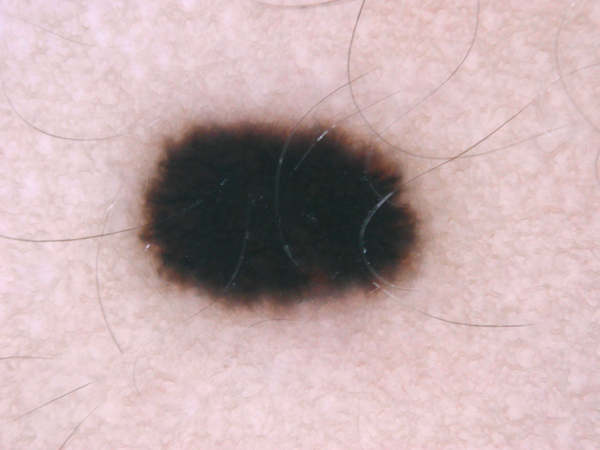

In [135]:
img

In [136]:
img.size

(600, 450)

In [137]:
(600-450)/2

75.0

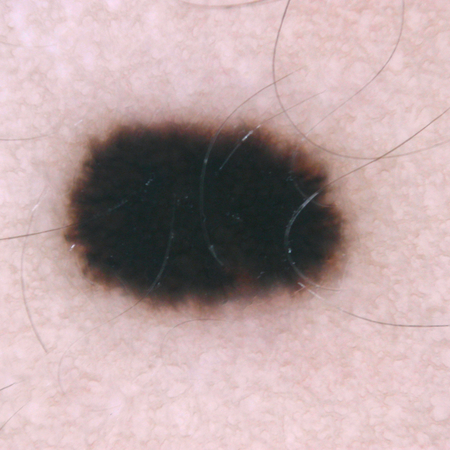

In [138]:
img.crop((75, 0, 450+75, 450))

In [145]:
img.crop((75, 0, 525, 450)).size

(450, 450)

In [143]:
left, top, right, bottom

(75.0, 0.0, 525.0, 450.0)

In [140]:
width, height = img.size
new_width = height
new_height = height
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

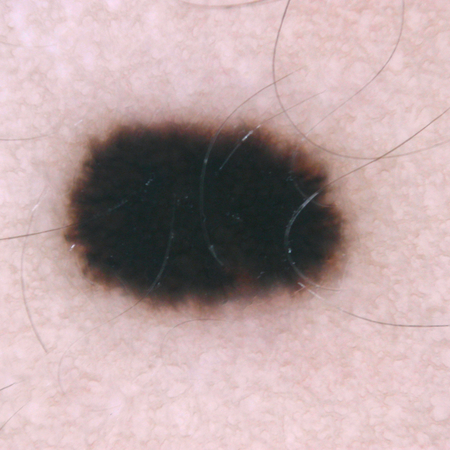

In [146]:
img.crop((left, top, right, bottom))

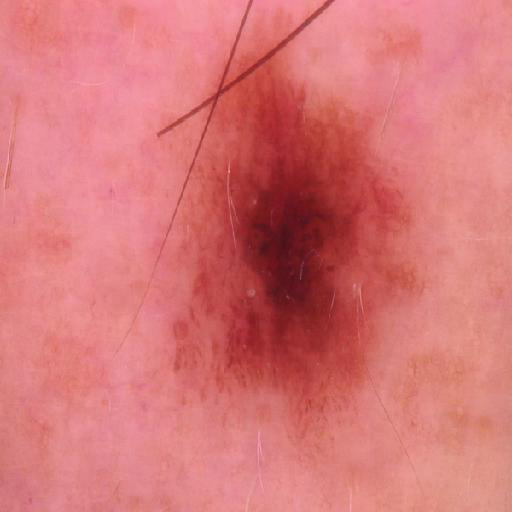

In [31]:
Image.open("data/all/ISIC_0024306.jpg")